TypeError: argument of type 'numpy.float64' is not iterable

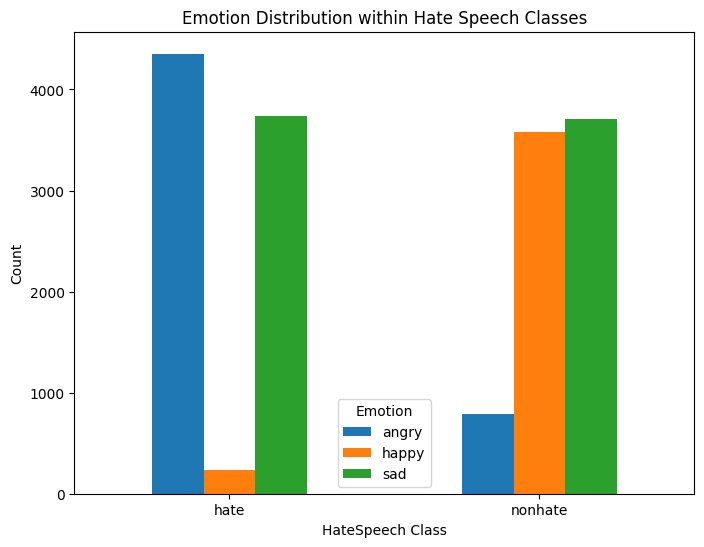

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv("BanEmoHate.csv")

# Group by HateSpeech and Emotion
grouped = df.groupby(["Hate Comments", "Emotion"]).size().unstack(fill_value=0)

# Plot grouped bar chart
ax = grouped.plot(kind="bar", figsize=(8,6))
plt.title("Emotion Distribution within Hate Speech Classes")
plt.xlabel("HateSpeech")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Emotion")

# Annotate counts + percentages on bars
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            total = grouped.loc[bar.get_x() + bar.get_width()/2 in bar.get_x(), :].sum() # incorrect method


In [ ]:
!pip install --upgrade transformers
import importlib
importlib.reload(__import__('transformers'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 133.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.1
    Uninstalling transformers-4.56.1:
      Successfully uninstalled transformers-4.56.1


<module 'transformers' from '/usr/local/lib/python3.12/dist-packages/transformers/__init__.py'>

In [ ]:
# 1️⃣ Disable W&B
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# 2️⃣ Install required packages
!pip install -q transformers datasets scikit-learn torch accelerate openpyxl
!pip install --upgrade transformers

In [ ]:
!pip install transformers datasets torch

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel

In [ ]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer
from sklearn.model_selection import train_test_split

In [ ]:
# 4️⃣ Load CSV
df = pd.read_csv("/content/BanEmoHate.csv")
df.columns = df.columns.str.strip()

In [ ]:
import re
# -------------------------------
# 2. Drop missing & duplicates
# -------------------------------
df = df.dropna(subset=["Comments", "HateSpeech", "Emotion"])
df = df.drop_duplicates()
print("After drop:", df.shape)

# -------------------------------
# 3. Clean Bangla text
# -------------------------------
def clean_bangla_text(Comments):
    text = str(Comments)

    # Remove URLs
    text = re.sub(r"http\S+|www\S+", " ", text)

    # Remove English letters & numbers
    text = re.sub(r"[a-zA-Z0-9]", " ", text)

    # Remove punctuation & symbols (keep only Bangla unicode range)
    text = re.sub(r"[^\u0980-\u09FF\s]", " ", text)

    # Normalize multiple spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

df["text"] = df["Comments"].apply(clean_bangla_text)

# -------------------------------
# 4. Map labels
# -------------------------------
# Example (change if your dataset already has numeric labels):
emotion_map = {"sad": 0, "angry": 1, "happy": 2}   # happy, sad, angry
hate_map = {"hate": 1, "nonhate": 0}                 # hate=1, not-hate=0

df["emotion"] = df["Emotion"].map(emotion_map).astype(int)
df["hate"] = df["HateSpeech"].map(hate_map).astype(int)

# -------------------------------
# 5. Train/Validation Split
# -------------------------------
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print("Train size:", train_df.shape)
print("Validation size:", val_df.shape)
print(train_df.head())

After drop: (15940, 3)
Train size: (12752, 6)
Validation size: (3188, 6)
                                                Comments HateSpeech Emotion  \
2909   কথা বলছে জনসভায়। মনে হচ্ছে সিনেমার ডাইলোগ দিচ্...       hate     sad   
12502  মানুষের থেকে দূরে থাকা ভালো। একা থাকা ভালো, মা...    nonhate     sad   
6794                         শরেন তো একটু দেখি কই ডাকাত!    nonhate     sad   
1670                                  তুই নষ্ট মেয়ে সালি       hate   angry   
4669                                   মারা খাওয়ার লক্ষন       hate   angry   

                                                    text  emotion  hate  
2909   কথা বলছে জনসভায় মনে হচ্ছে সিনেমার ডাইলোগ দিচ্ছ...        0     1  
12502  মানুষের থেকে দূরে থাকা ভালো একা থাকা ভালো মানু...        0     0  
6794                          শরেন তো একটু দেখি কই ডাকাত        0     0  
1670                                  তুই নষ্ট মেয়ে সালি        1     1  
4669                                   মারা খাওয়ার লক্ষন        1     1  


In [ ]:
MODEL_NAME = "xlm-roberta-base"   # you can try "xlm-roberta-large" or "sagorsarker/bangla-bert-base"
MAX_LEN = 128
BATCH_SIZE = 16
LR = 1e-5
EPOCHS = 20
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class TextDataset(Dataset):
    def __init__(self, texts, emotion_labels, hate_labels, tokenizer, max_len=MAX_LEN):
        self.texts = texts
        self.emotion_labels = emotion_labels
        self.hate_labels = hate_labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "emotion": torch.tensor(self.emotion_labels[idx], dtype=torch.long),
            "hate": torch.tensor(self.hate_labels[idx], dtype=torch.long)
        }

train_dataset = TextDataset(train_df["text"].tolist(),
                            train_df["emotion"].tolist(),
                            train_df["hate"].tolist(),
                            tokenizer)

val_dataset = TextDataset(val_df["text"].tolist(),
                          val_df["emotion"].tolist(),
                          val_df["hate"].tolist(),
                          tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# =========================================================
# 9. Multi-task Model
# =========================================================
class MultiTaskModel(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_emotions=3, num_hates=2, hidden_dim=256, dropout=0.3):
        super(MultiTaskModel, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        encoder_hidden = self.encoder.config.hidden_size

        # Emotion classifier head (MLP)
        self.emotion_head = nn.Sequential(
            nn.Linear(encoder_hidden, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_emotions)
        )

        # Hate classifier head (MLP)
        self.hate_head = nn.Sequential(
            nn.Linear(encoder_hidden, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_hates)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = outputs.last_hidden_state[:, 0, :]  # [CLS] representation

        emotion_logits = self.emotion_head(cls_token)
        hate_logits = self.hate_head(cls_token)

        return emotion_logits, hate_logits

# Instantiate the model
model = MultiTaskModel().to(DEVICE)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Epoch 1/20
 Train Loss: 1.4728 | Val Loss: 1.2008
 Emotion Acc: 0.6562 | F1: 0.6471
 Hate Acc: 0.7992 | F1: 0.7989
Epoch 2/20
 Train Loss: 1.1879 | Val Loss: 1.1028
 Emotion Acc: 0.6829 | F1: 0.6765
 Hate Acc: 0.8093 | F1: 0.8082
Epoch 3/20
 Train Loss: 1.0548 | Val Loss: 1.0559
 Emotion Acc: 0.7026 | F1: 0.7029
 Hate Acc: 0.8284 | F1: 0.8283
Epoch 4/20
 Train Loss: 0.9700 | Val Loss: 1.0458
 Emotion Acc: 0.7120 | F1: 0.7108
 Hate Acc: 0.8394 | F1: 0.8392
Epoch 5/20
 Train Loss: 0.8783 | Val Loss: 1.0660
 Emotion Acc: 0.7158 | F1: 0.7163
 Hate Acc: 0.8400 | F1: 0.8400
Epoch 6/20
 Train Loss: 0.8027 | Val Loss: 1.0905
 Emotion Acc: 0.7117 | F1: 0.7113
 Hate Acc: 0.8432 | F1: 0.8431
Epoch 7/20
 Train Loss: 0.7880 | Val Loss: 1.0934
 Emotion Acc: 0.7108 | F1: 0.7109
 Hate Acc: 0.8400 | F1: 0.8399
Epoch 8/20
 Train Loss: 0.6812 | Val Loss: 1.1225
 Emotion Acc: 0.7117 | F1: 0.7118
 Hate Acc: 0.8454 | F1: 0.8453
Epoch 9/20
 Train Loss: 0.5907 | Val Loss: 1.2069
 Emotion Acc: 0.7089 | F1: 0.7

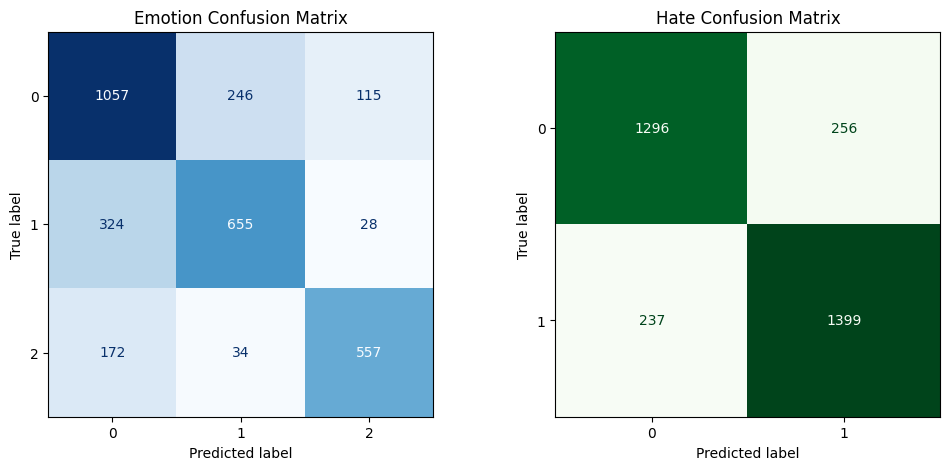

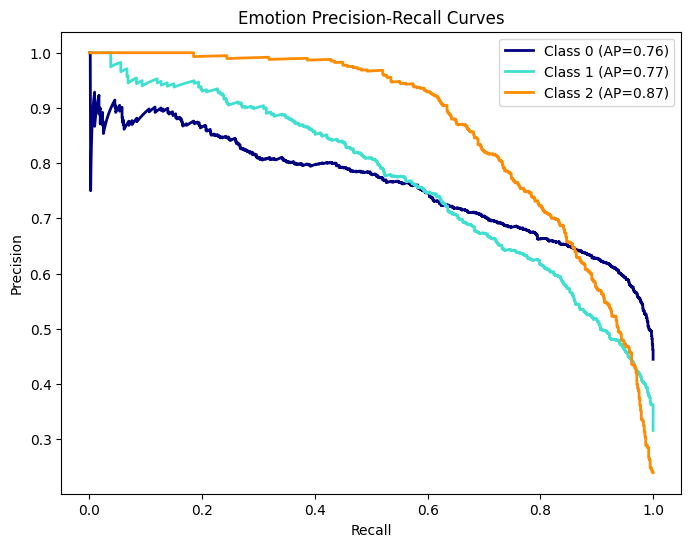

Emotion mAP: 0.7992


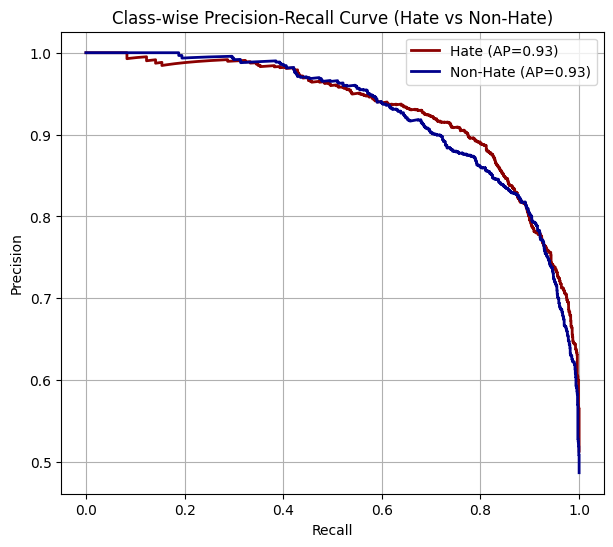

Hate AP: 0.9301
Non-Hate AP: 0.9262
Hate AP: 0.9301


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score
)
from itertools import cycle

# =========================================================
# Optimizer & Loss
# =========================================================
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion_emotion = nn.CrossEntropyLoss()
criterion_hate = nn.CrossEntropyLoss()

# =========================================================
# Training & Evaluation Functions
# =========================================================
def train_model(model, dataloader):
    model.train()
    total_loss = 0

    all_emotion_preds, all_emotion_labels = [], []
    all_hate_preds, all_hate_labels = [], []

    for batch in dataloader:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        emotion_labels = batch["emotion"].to(DEVICE)
        hate_labels = batch["hate"].to(DEVICE)

        optimizer.zero_grad()
        emotion_logits, hate_logits = model(input_ids, attention_mask)
        loss_emotion = criterion_emotion(emotion_logits, emotion_labels)
        loss_hate = criterion_hate(hate_logits, hate_labels)
        loss = loss_emotion + loss_hate
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Predictions
        emotion_preds = torch.argmax(emotion_logits, dim=1)
        hate_preds = torch.argmax(hate_logits, dim=1)

        all_emotion_preds.extend(emotion_preds.cpu().numpy())
        all_emotion_labels.extend(emotion_labels.cpu().numpy())
        all_hate_preds.extend(hate_preds.cpu().numpy())
        all_hate_labels.extend(hate_labels.cpu().numpy())

    train_metrics = {
        "emotion_acc": accuracy_score(all_emotion_labels, all_emotion_preds),
        "emotion_f1": f1_score(all_emotion_labels, all_emotion_preds, average="weighted"),
        "hate_acc": accuracy_score(all_hate_labels, all_hate_preds),
        "hate_f1": f1_score(all_hate_labels, all_hate_preds, average="weighted"),
    }
    return total_loss / len(dataloader), train_metrics


def eval_model(model, dataloader):
    model.eval()
    total_loss = 0

    all_emotion_preds, all_emotion_labels = [], []
    all_hate_preds, all_hate_labels = [], []
    all_emotion_probs, all_hate_probs = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            emotion_labels = batch["emotion"].to(DEVICE)
            hate_labels = batch["hate"].to(DEVICE)

            emotion_logits, hate_logits = model(input_ids, attention_mask)
            loss_emotion = criterion_emotion(emotion_logits, emotion_labels)
            loss_hate = criterion_hate(hate_logits, hate_labels)
            total_loss += (loss_emotion + loss_hate).item()

            # Predictions
            emotion_preds = torch.argmax(emotion_logits, dim=1)
            hate_preds = torch.argmax(hate_logits, dim=1)

            all_emotion_preds.extend(emotion_preds.cpu().numpy())
            all_emotion_labels.extend(emotion_labels.cpu().numpy())
            all_hate_preds.extend(hate_preds.cpu().numpy())
            all_hate_labels.extend(hate_labels.cpu().numpy())

            # Probabilities (for PR curve & mAP)
            all_emotion_probs.extend(torch.softmax(emotion_logits, dim=1).cpu().numpy())
            all_hate_probs.extend(torch.softmax(hate_logits, dim=1).cpu().numpy())

    avg_loss = total_loss / len(dataloader)

    metrics = {
        "emotion_acc": accuracy_score(all_emotion_labels, all_emotion_preds),
        "emotion_prec": precision_score(all_emotion_labels, all_emotion_preds, average="weighted"),
        "emotion_rec": recall_score(all_emotion_labels, all_emotion_preds, average="weighted"),
        "emotion_f1": f1_score(all_emotion_labels, all_emotion_preds, average="weighted"),
        "hate_acc": accuracy_score(all_hate_labels, all_hate_preds),
        "hate_prec": precision_score(all_hate_labels, all_hate_preds, average="weighted"),
        "hate_rec": recall_score(all_hate_labels, all_hate_preds, average="weighted"),
        "hate_f1": f1_score(all_hate_labels, all_hate_preds, average="weighted"),
        "emotion_cm": confusion_matrix(all_emotion_labels, all_emotion_preds),
        "hate_cm": confusion_matrix(all_hate_labels, all_hate_preds),
        "emotion_labels": np.array(all_emotion_labels),
        "emotion_preds": np.array(all_emotion_preds),
        "hate_labels": np.array(all_hate_labels),
        "hate_preds": np.array(all_hate_preds),
        "emotion_probs": np.array(all_emotion_probs),
        "hate_probs": np.array(all_hate_probs),
    }
    return avg_loss, metrics

# =========================================================
# Training Loop
# =========================================================
best_emotion_acc, best_emotion_f1 = 0, 0
best_hate_acc, best_hate_f1 = 0, 0
best_metrics = None

for epoch in range(EPOCHS):
    train_loss, train_metrics = train_model(model, train_loader)
    val_loss, val_metrics = eval_model(model, val_loader)

    # Track best metrics
    if val_metrics["emotion_acc"] > best_emotion_acc:
        best_emotion_acc = val_metrics["emotion_acc"]
    if val_metrics["emotion_f1"] > best_emotion_f1:
        best_emotion_f1 = val_metrics["emotion_f1"]
    if val_metrics["hate_acc"] > best_hate_acc:
        best_hate_acc = val_metrics["hate_acc"]
    if val_metrics["hate_f1"] > best_hate_f1:
        best_hate_f1 = val_metrics["hate_f1"]
        best_metrics = val_metrics  # keep best epoch outputs

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f" Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f" Emotion Acc: {val_metrics['emotion_acc']:.4f} | F1: {val_metrics['emotion_f1']:.4f}")
    print(f" Hate Acc: {val_metrics['hate_acc']:.4f} | F1: {val_metrics['hate_f1']:.4f}")

print("\n==== BEST METRICS ====")
print(f"Emotion Acc: {best_emotion_acc:.4f}, F1: {best_emotion_f1:.4f}")
print(f"Hate Acc: {best_hate_acc:.4f}, F1: {best_hate_f1:.4f}")

# =========================================================
# Confusion Matrices (Best Epoch)
# =========================================================
fig, axes = plt.subplots(1, 2, figsize=(12,5))
ConfusionMatrixDisplay(best_metrics["emotion_cm"]).plot(ax=axes[0], cmap="Blues", colorbar=False)
axes[0].set_title("Emotion Confusion Matrix")

ConfusionMatrixDisplay(best_metrics["hate_cm"]).plot(ax=axes[1], cmap="Greens", colorbar=False)
axes[1].set_title("Hate Confusion Matrix")
plt.show()

# =========================================================
# Mean Average Precision (mAP) and Precision–Recall Curves
# =========================================================
# Emotion (multi-class)
y_true_emotion = best_metrics["emotion_labels"]
y_prob_emotion = best_metrics["emotion_probs"]
n_classes = y_prob_emotion.shape[1]

# One-hot encode
y_true_onehot = np.zeros((len(y_true_emotion), n_classes))
y_true_onehot[np.arange(len(y_true_emotion)), y_true_emotion] = 1

ap_emotion = []
plt.figure(figsize=(8,6))
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])
for i, color in zip(range(n_classes), colors):
    precision, recall, _ = precision_recall_curve(y_true_onehot[:, i], y_prob_emotion[:, i])
    ap = average_precision_score(y_true_onehot[:, i], y_prob_emotion[:, i])
    ap_emotion.append(ap)
    plt.plot(recall, precision, color=color, lw=2,
             label=f"Class {i} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Emotion Precision-Recall Curves")
plt.legend()
plt.show()

map_emotion = np.mean(ap_emotion)
print(f"Emotion mAP: {map_emotion:.4f}")

# Ground truth and predicted probabilities
y_true_hate = best_metrics["hate_labels"]               # [0,1,...]
y_prob_hate = best_metrics["hate_probs"][:,1]           # Prob for "Hate"
y_prob_nonhate = best_metrics["hate_probs"][:,0]        # Prob for "Non-Hate"

# Hate (positive class = 1)
precision_hate, recall_hate, _ = precision_recall_curve(y_true_hate, y_prob_hate, pos_label=1)
ap_hate = average_precision_score(y_true_hate, y_prob_hate, pos_label=1)

# Non-Hate (positive class = 0)
precision_non, recall_non, _ = precision_recall_curve(y_true_hate, y_prob_nonhate, pos_label=0)
ap_non = average_precision_score(y_true_hate, y_prob_nonhate, pos_label=0)

# Plot PR Curves
plt.figure(figsize=(7,6))
plt.plot(recall_hate, precision_hate, lw=2, color="darkred", label=f"Hate (AP={ap_hate:.2f})")
plt.plot(recall_non, precision_non, lw=2, color="darkblue", label=f"Non-Hate (AP={ap_non:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Class-wise Precision-Recall Curve (Hate vs Non-Hate)")
plt.legend()
plt.grid()
plt.show()

print(f"Hate AP: {ap_hate:.4f}")
print(f"Non-Hate AP: {ap_non:.4f}")
print(f"Hate AP: {ap_hate:.4f}")


In [ ]:
import torch
from transformers import AutoTokenizer

# Load tokenizer (XLM-RoBERTa)
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

# Example sentence
test_sentence = "ওর পুরা গুষ্টি শ্বশুরের গুষ্টি বাপের গুষ্টি সবার সকল সম্পত্তি বাজেয়াপ্ত করা হোক স্থাবর অস্থাবর সব।"

# Tokenize
inputs = tokenizer(
    test_sentence,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=128
)

# Move to device
inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

# Model inference
model.eval()
with torch.no_grad():
    emotion_logits, hate_logits = model(inputs["input_ids"], inputs["attention_mask"])

# Predictions
emotion_pred = torch.argmax(emotion_logits, dim=1).item()
hate_pred = torch.argmax(hate_logits, dim=1).item()

# Map labels (adjust according to your dataset!)
emotion_map = {0: "Happy", 1: "Sad", 2: "Angry"}
hate_map = {0: "Non-Hate", 1: "Hate"}

print("Input Sentence:", test_sentence)
print("Predicted Emotion:", emotion_map[emotion_pred])
print("Predicted Hate Speech:", hate_map[hate_pred])


Input Sentence: ওর পুরা গুষ্টি শ্বশুরের গুষ্টি বাপের গুষ্টি সবার সকল সম্পত্তি বাজেয়াপ্ত করা হোক স্থাবর অস্থাবর সব।
Predicted Emotion: Sad
Predicted Hate Speech: Non-Hate


In [ ]:
import torch
from transformers import AutoTokenizer

# Load tokenizer (XLM-RoBERTa)
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

# Example sentence
test_sentence = "অনশন প্রথা যে বের করছে তাকে নোবেল দেওয়া হোক"

# Tokenize
inputs = tokenizer(
    test_sentence,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=128
)

# Move to device
inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

# Model inference
model.eval()
with torch.no_grad():
    emotion_logits, hate_logits = model(inputs["input_ids"], inputs["attention_mask"])

# Predictions
emotion_pred = torch.argmax(emotion_logits, dim=1).item()
hate_pred = torch.argmax(hate_logits, dim=1).item()

# Map labels (adjust according to your dataset!)
emotion_map = {0: "Happy", 1: "Sad", 2: "Angry"}
hate_map = {0: "Non-Hate", 1: "Hate"}

print("Input Sentence:", test_sentence)
print("Predicted Emotion:", emotion_map[emotion_pred])
print("Predicted Hate Speech:", hate_map[hate_pred])


Input Sentence: অনশন প্রথা যে বের করছে তাকে নোবেল দেওয়া হোক
Predicted Emotion: Angry
Predicted Hate Speech: Non-Hate


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
 Train Loss: 1.7482 | Val Loss: 1.7591
 Emotion Acc: 0.4451 | F1: 0.2746
 Hate Acc: 0.5132 | F1: 0.3481
Epoch 2/10
 Train Loss: 1.4140 | Val Loss: 1.1821
 Emotion Acc: 0.6578 | F1: 0.6455
 Hate Acc: 0.7873 | F1: 0.7852
Epoch 3/10
 Train Loss: 1.1329 | Val Loss: 1.1742
 Emotion Acc: 0.6710 | F1: 0.6547
 Hate Acc: 0.7880 | F1: 0.7833
Epoch 4/10
 Train Loss: 1.0053 | Val Loss: 1.0653
 Emotion Acc: 0.7004 | F1: 0.6905
 Hate Acc: 0.8262 | F1: 0.8255
Epoch 5/10
 Train Loss: 0.9043 | Val Loss: 1.0946
 Emotion Acc: 0.7136 | F1: 0.7120
 Hate Acc: 0.8403 | F1: 0.8403
Epoch 6/10
 Train Loss: 0.8184 | Val Loss: 1.0282
 Emotion Acc: 0.7218 | F1: 0.7225
 Hate Acc: 0.8381 | F1: 0.8382
Epoch 7/10
 Train Loss: 0.7536 | Val Loss: 1.1313
 Emotion Acc: 0.7117 | F1: 0.7094
 Hate Acc: 0.8488 | F1: 0.8488
Epoch 8/10
 Train Loss: 0.6545 | Val Loss: 1.1506
 Emotion Acc: 0.7158 | F1: 0.7163
 Hate Acc: 0.8476 | F1: 0.8474
Epoch 9/10
 Train Loss: 0.5712 | Val Loss: 1.2295
 Emotion Acc: 0.7177 | F1: 0.7

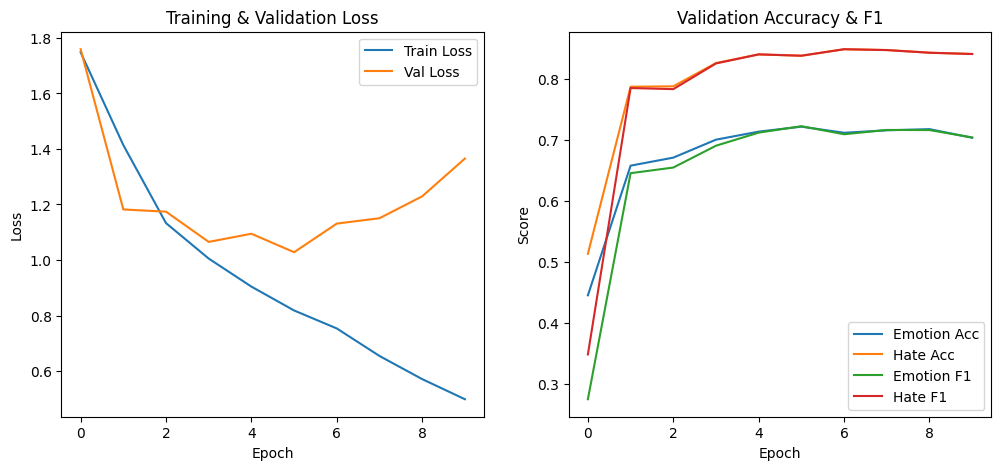

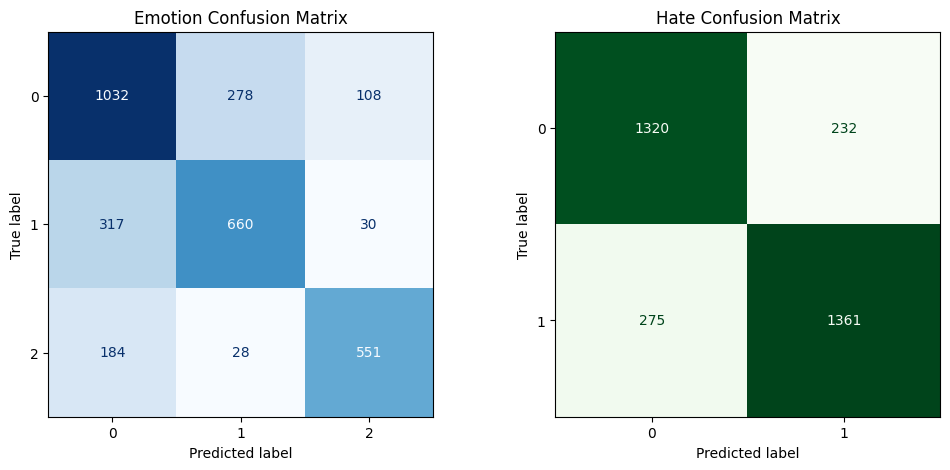

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# =========================================================
# Optimizer & Loss
# =========================================================
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion_emotion = nn.CrossEntropyLoss()
criterion_hate = nn.CrossEntropyLoss()

# =========================================================
# Training & Evaluation Functions
# =========================================================
def train_model(model, dataloader):
    model.train()
    total_loss = 0

    # Initialize lists to store predictions and labels for metrics
    all_emotion_preds, all_emotion_labels = [], []
    all_hate_preds, all_hate_labels = [], []

    for batch in dataloader:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        emotion_labels = batch["emotion"].to(DEVICE)
        hate_labels = batch["hate"].to(DEVICE)

        optimizer.zero_grad()
        emotion_logits, hate_logits = model(input_ids, attention_mask)
        loss_emotion = criterion_emotion(emotion_logits, emotion_labels)
        loss_hate = criterion_hate(hate_logits, hate_labels)
        loss = loss_emotion + loss_hate
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Store predictions and labels for metrics
        emotion_preds = torch.argmax(emotion_logits, dim=1)
        hate_preds = torch.argmax(hate_logits, dim=1)

        all_emotion_preds.extend(emotion_preds.cpu().numpy())
        all_emotion_labels.extend(emotion_labels.cpu().numpy())
        all_hate_preds.extend(hate_preds.cpu().numpy())
        all_hate_labels.extend(hate_labels.cpu().numpy())


    # Calculate and return metrics for the training set
    train_metrics = {
        "emotion_acc": accuracy_score(all_emotion_labels, all_emotion_preds),
        "emotion_f1": f1_score(all_emotion_labels, all_emotion_preds, average="weighted"),
        "hate_acc": accuracy_score(all_hate_labels, all_hate_preds),
        "hate_f1": f1_score(all_hate_labels, all_hate_preds, average="weighted"),
    }
    return total_loss / len(dataloader), train_metrics


def eval_model(model, dataloader):
    model.eval()
    total_loss = 0

    all_emotion_preds, all_emotion_labels = [], []
    all_hate_preds, all_hate_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            emotion_labels = batch["emotion"].to(DEVICE)
            hate_labels = batch["hate"].to(DEVICE)

            emotion_logits, hate_logits = model(input_ids, attention_mask)
            loss_emotion = criterion_emotion(emotion_logits, emotion_labels)
            loss_hate = criterion_hate(hate_logits, hate_labels)
            total_loss += (loss_emotion + loss_hate).item()

            # Predictions
            emotion_preds = torch.argmax(emotion_logits, dim=1)
            hate_preds = torch.argmax(hate_logits, dim=1)

            all_emotion_preds.extend(emotion_preds.cpu().numpy())
            all_emotion_labels.extend(emotion_labels.cpu().numpy())
            all_hate_preds.extend(hate_preds.cpu().numpy())
            all_hate_labels.extend(hate_labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)

    # Metrics
    metrics = {
        "emotion_acc": accuracy_score(all_emotion_labels, all_emotion_preds),
        "emotion_prec": precision_score(all_emotion_labels, all_emotion_preds, average="weighted"),
        "emotion_rec": recall_score(all_emotion_labels, all_emotion_preds, average="weighted"),
        "emotion_f1": f1_score(all_emotion_labels, all_emotion_preds, average="weighted"),
        "hate_acc": accuracy_score(all_hate_labels, all_hate_preds),
        "hate_prec": precision_score(all_hate_labels, all_hate_preds, average="weighted"),
        "hate_rec": recall_score(all_hate_labels, all_hate_preds, average="weighted"),
        "hate_f1": f1_score(all_hate_labels, all_hate_preds, average="weighted"),
        "emotion_cm": confusion_matrix(all_emotion_labels, all_emotion_preds),
        "hate_cm": confusion_matrix(all_hate_labels, all_hate_preds),
        "emotion_labels": all_emotion_labels, # Return labels and predictions for confusion matrix plotting
        "emotion_preds": all_emotion_preds,
        "hate_labels": all_hate_labels,
        "hate_preds": all_hate_preds,
    }
    return avg_loss, metrics

# =========================================================
# Training Loop
# =========================================================
train_losses, val_losses = [], []
train_emotion_accs, val_emotion_accs = [], []
train_hate_accs, val_hate_accs = [], []
train_emotion_f1s, val_emotion_f1s = [], []
train_hate_f1s, val_hate_f1s = [], []


for epoch in range(EPOCHS):
    train_loss, train_metrics = train_model(model, train_loader)
    val_loss, val_metrics = eval_model(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_emotion_accs.append(train_metrics["emotion_acc"])
    val_emotion_accs.append(val_metrics["emotion_acc"])
    train_hate_accs.append(train_metrics["hate_acc"])
    val_hate_accs.append(val_metrics["hate_acc"])
    train_emotion_f1s.append(train_metrics["emotion_f1"])
    val_emotion_f1s.append(val_metrics["emotion_f1"])
    train_hate_f1s.append(train_metrics["hate_f1"])
    val_hate_f1s.append(val_metrics["hate_f1"])


    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f" Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f" Emotion Acc: {val_metrics['emotion_acc']:.4f} | F1: {val_metrics['emotion_f1']:.4f}")
    print(f" Hate Acc: {val_metrics['hate_acc']:.4f} | F1: {val_metrics['hate_f1']:.4f}")

# =========================================================
# Plot Loss Curves
# =========================================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# =========================================================
# Plot Accuracy & F1 Curves
# =========================================================
plt.subplot(1,2,2)
plt.plot(val_emotion_accs, label="Emotion Acc")
plt.plot(val_hate_accs, label="Hate Acc")
plt.plot(val_emotion_f1s, label="Emotion F1")
plt.plot(val_hate_f1s, label="Hate F1")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Accuracy & F1")
plt.legend()
plt.show()

# =========================================================
# Final Confusion Matrices
# =========================================================
fig, axes = plt.subplots(1, 2, figsize=(12,5))
ConfusionMatrixDisplay(val_metrics["emotion_cm"]).plot(ax=axes[0], cmap="Blues", colorbar=False)
axes[0].set_title("Emotion Confusion Matrix")

ConfusionMatrixDisplay(val_metrics["hate_cm"]).plot(ax=axes[1], cmap="Greens", colorbar=False)
axes[1].set_title("Hate Confusion Matrix")
plt.show()


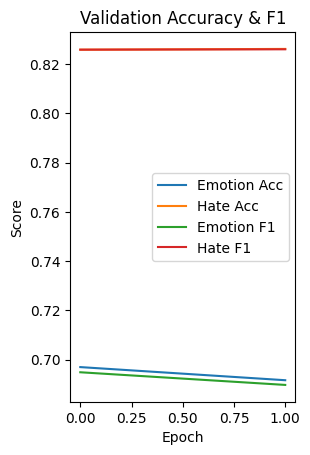

In [ ]:
# 10. Training Setup
# =========================================================
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion_emotion = nn.CrossEntropyLoss()
criterion_hate = nn.CrossEntropyLoss()

# To store curves
train_losses, val_losses = [], []
train_accs_emotion, val_accs_emotion = [], []
train_accs_hate, val_accs_hate = [], []
train_f1s_emotion, val_f1s_emotion = [], []
train_f1s_hate, val_f1s_hate = [], []


In [ ]:

# ---------------------------------------------------------
# Training Function
# ---------------------------------------------------------
def train_model(model, dataloader):
    model.train()
    total_loss = 0
    all_emotion_preds, all_emotion_labels = [], []
    all_hate_preds, all_hate_labels = [], []

    for batch in dataloader:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        emotion_labels = batch["emotion"].to(DEVICE)
        hate_labels = batch["hate"].to(DEVICE)

        optimizer.zero_grad()
        emotion_logits, hate_logits = model(input_ids, attention_mask)

        # Loss
        loss_emotion = criterion_emotion(emotion_logits, emotion_labels)
        loss_hate = criterion_hate(hate_logits, hate_labels)
        loss = loss_emotion + loss_hate
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Predictions
        emotion_preds = torch.argmax(emotion_logits, dim=1)
        hate_preds = torch.argmax(hate_logits, dim=1)

        all_emotion_preds.extend(emotion_preds.cpu().numpy())
        all_emotion_labels.extend(emotion_labels.cpu().numpy())
        all_hate_preds.extend(hate_preds.cpu().numpy())
        all_hate_labels.extend(hate_labels.cpu().numpy())

    # Metrics
    train_acc_emotion = accuracy_score(all_emotion_labels, all_emotion_preds)
    train_f1_emotion = f1_score(all_emotion_labels, all_emotion_preds, average="weighted")
    train_acc_hate = accuracy_score(all_hate_labels, all_hate_preds)
    train_f1_hate = f1_score(all_hate_labels, all_hate_preds, average="weighted")

    return total_loss / len(dataloader), train_acc_emotion, train_f1_emotion, train_acc_hate, train_f1_hate

In [ ]:
# Validation Function
# ---------------------------------------------------------
def eval_model(model, dataloader):
    model.eval()
    total_loss = 0
    all_emotion_preds, all_emotion_labels = [], []
    all_hate_preds, all_hate_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            emotion_labels = batch["emotion"].to(DEVICE)
            hate_labels = batch["hate"].to(DEVICE)

            emotion_logits, hate_logits = model(input_ids, attention_mask)

            loss_emotion = criterion_emotion(emotion_logits, emotion_labels)
            loss_hate = criterion_hate(hate_logits, hate_labels)
            total_loss += (loss_emotion + loss_hate).item()

            emotion_preds = torch.argmax(emotion_logits, dim=1)
            hate_preds = torch.argmax(hate_logits, dim=1)

            all_emotion_preds.extend(emotion_preds.cpu().numpy())
            all_emotion_labels.extend(emotion_labels.cpu().numpy())
            all_hate_preds.extend(hate_preds.cpu().numpy())
            all_hate_labels.extend(hate_labels.cpu().numpy())

    # Metrics
    val_acc_emotion = accuracy_score(all_emotion_labels, all_emotion_preds)
    val_f1_emotion = f1_score(all_emotion_labels, all_emotion_preds, average="weighted")
    val_acc_hate = accuracy_score(all_hate_labels, all_hate_preds)
    val_f1_hate = f1_score(all_hate_labels, all_hate_preds, average="weighted")

    return total_loss / len(dataloader), val_acc_emotion, val_f1_emotion, val_acc_hate, val_f1_hate

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/3 | Train Loss: 1.7541 | Val Loss: 1.7599 | Emotion Acc: 0.4448, Hate Acc: 0.5132


KeyboardInterrupt: 

Epoch 1/3 | Train Loss: 1.6728 | Val Loss: 1.7629
Emotion -> Train Acc: 0.4801, Val Acc: 0.4448, Train F1: 0.4336, Val F1: 0.2739
Hate    -> Train Acc: 0.5905, Val Acc: 0.5132, Train F1: 0.5903, Val F1: 0.3481
Epoch 2/3 | Train Loss: 1.7644 | Val Loss: 1.7604
Emotion -> Train Acc: 0.4591, Val Acc: 0.4448, Train F1: 0.3072, Val F1: 0.2739
Hate    -> Train Acc: 0.4907, Val Acc: 0.5132, Train F1: 0.4906, Val F1: 0.3481
Epoch 3/3 | Train Loss: 1.7590 | Val Loss: 1.7617
Emotion -> Train Acc: 0.4611, Val Acc: 0.4448, Train F1: 0.2985, Val F1: 0.2739
Hate    -> Train Acc: 0.5016, Val Acc: 0.4868, Train F1: 0.5016, Val F1: 0.3188


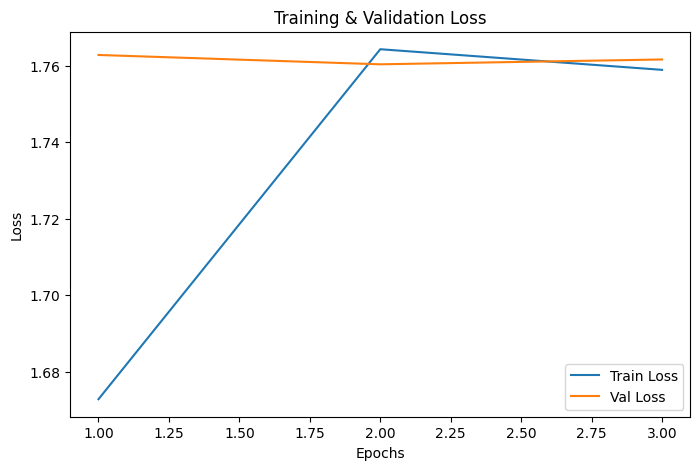

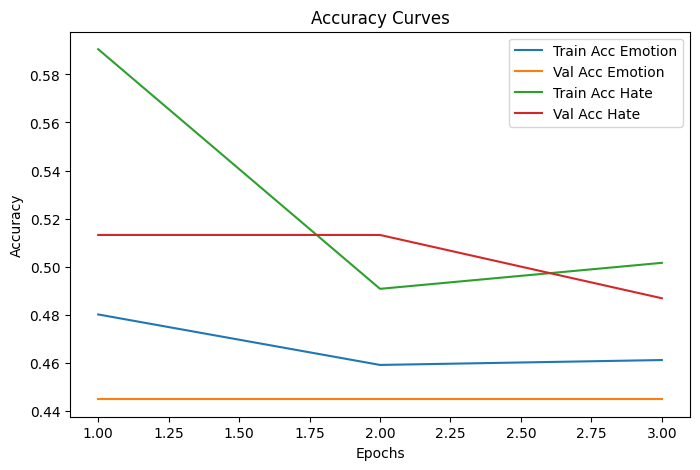

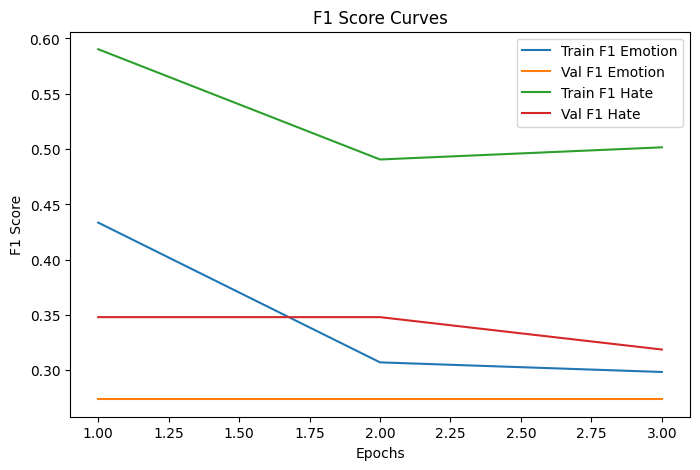

NameError: name 'confusion_matrix' is not defined

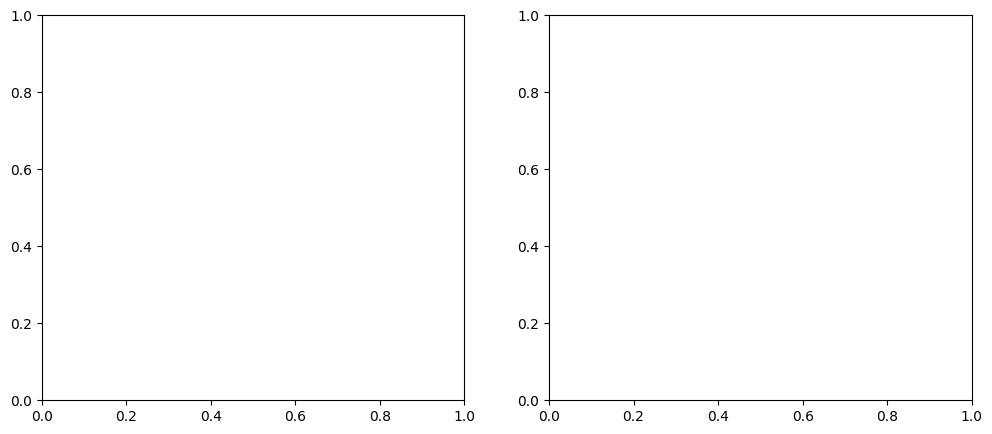

In [ ]:
# =========================================================
# 11. Run Training
# =========================================================
for epoch in range(EPOCHS):
    train_loss, tr_acc_e, tr_f1_e, tr_acc_h, tr_f1_h = train_model(model, train_loader)
    val_loss, val_acc_e, val_f1_e, val_acc_h, val_f1_h = eval_model(model, val_loader)
    val_loss, emo_labels, emo_preds, hate_labels, hate_preds = eval_model(model, val_loader)

    # Store for curves
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs_emotion.append(tr_acc_e)
    val_accs_emotion.append(val_acc_e)
    train_accs_hate.append(tr_acc_h)
    val_accs_hate.append(val_acc_h)
    train_f1s_emotion.append(tr_f1_e)
    val_f1s_emotion.append(val_f1_e)
    train_f1s_hate.append(tr_f1_h)
    val_f1s_hate.append(val_f1_h)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Emotion -> Train Acc: {tr_acc_e:.4f}, Val Acc: {val_acc_e:.4f}, Train F1: {tr_f1_e:.4f}, Val F1: {val_f1_e:.4f}")
    print(f"Hate    -> Train Acc: {tr_acc_h:.4f}, Val Acc: {val_acc_h:.4f}, Train F1: {tr_f1_h:.4f}, Val F1: {val_f1_h:.4f}")

# =========================================================
# 12. Plot Curves
# =========================================================
epochs = range(1, EPOCHS+1)

# Loss Curves
plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# Accuracy Curves
plt.figure(figsize=(8,5))
plt.plot(epochs, train_accs_emotion, label="Train Acc Emotion")
plt.plot(epochs, val_accs_emotion, label="Val Acc Emotion")
plt.plot(epochs, train_accs_hate, label="Train Acc Hate")
plt.plot(epochs, val_accs_hate, label="Val Acc Hate")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.show()

# F1 Score Curves
plt.figure(figsize=(8,5))
plt.plot(epochs, train_f1s_emotion, label="Train F1 Emotion")
plt.plot(epochs, val_f1s_emotion, label="Val F1 Emotion")
plt.plot(epochs, train_f1s_hate, label="Train F1 Hate")
plt.plot(epochs, val_f1s_hate, label="Val F1 Hate")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("F1 Score Curves")
plt.legend()
plt.show()

# Plot confusion matrices per epoch
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

cm_emotion = confusion_matrix(emo_labels, emo_preds)
sns.heatmap(cm_emotion, annot=True, fmt="d", cmap="Blues", ax=axs[0])
axs[0].set_title(f"Emotion Confusion Matrix (Epoch {epoch+1})")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

cm_hate = confusion_matrix(hate_labels, hate_preds)
sns.heatmap(cm_hate, annot=True, fmt="d", cmap="Greens", ax=axs[1])
axs[1].set_title(f"Hate Confusion Matrix (Epoch {epoch+1})")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import torch

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Make sure your model is also on the same device
model.to(device)
# Put model in eval mode
model.eval()

all_emotion_preds = []
all_emotion_labels = []

all_hate_preds = []
all_hate_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        emotion_labels = batch['emotion'].to(device)
        hate_labels = batch['hate'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Assuming your model returns a tuple (emotion_logits, hate_logits)
        emotion_logits, hate_logits = outputs

        # Get predicted class
        emotion_preds = torch.argmax(emotion_logits, dim=1)
        hate_preds = torch.argmax(hate_logits, dim=1)

        # Store all predictions and labels
        all_emotion_preds.extend(emotion_preds.cpu().numpy())
        all_emotion_labels.extend(emotion_labels.cpu().numpy())

        all_hate_preds.extend(hate_preds.cpu().numpy())
        all_hate_labels.extend(hate_labels.cpu().numpy())

# Metrics for Emotion task
print("Emotion Task Metrics:")
print("Accuracy:", accuracy_score(all_emotion_labels, all_emotion_preds))
print("Precision:", precision_score(all_emotion_labels, all_emotion_preds, average='weighted'))
print("Recall:", recall_score(all_emotion_labels, all_emotion_preds, average='weighted'))
print("F1 Score:", f1_score(all_emotion_labels, all_emotion_preds, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(all_emotion_labels, all_emotion_preds))

# Metrics for HateSpeech task
print("\nHateSpeech Task Metrics:")
print("Accuracy:", accuracy_score(all_hate_labels, all_hate_preds))
print("Precision:", precision_score(all_hate_labels, all_hate_preds, average='weighted'))
print("Recall:", recall_score(all_hate_labels, all_hate_preds, average='weighted'))
print("F1 Score:", f1_score(all_hate_labels, all_hate_preds, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(all_hate_labels, all_hate_preds))


Using device: cuda
Emotion Task Metrics:
Accuracy: 0.7089084065244667
Precision: 0.7321316648913567
Recall: 0.7089084065244667
F1 Score: 0.7044756193410742
Confusion Matrix:
 [[1207  132   79]
 [ 451  537   19]
 [ 227   20  516]]

HateSpeech Task Metrics:
Accuracy: 0.8246549560853199
Precision: 0.8376114382889283
Recall: 0.8246549560853199
F1 Score: 0.8235046910801248
Confusion Matrix:
 [[1424  128]
 [ 431 1205]]


In [ ]:
   # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f"{task_name} Confusion Matrix")
    plt.show()

# Example: define your classes
emotion_classes = ['happy', 'sad', 'angry']  # modify according to your dataset
hate_classes = ['not_hate', 'hate']          # modify according to your dataset

# Print & plot metrics
print_metrics(all_emotion_labels, all_emotion_preds, "Emotion", emotion_classes)
print_metrics(all_hate_labels, all_hate_preds, "HateSpeech", hate_classes)

IndentationError: unexpected indent (ipython-input-3235770479.py, line 2)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_all_confusion_matrices(y_true_list, y_pred_list, class_names_list, task_names):
    """
    Plots multiple confusion matrices side by side.
    y_true_list, y_pred_list: lists of true/pred labels for each task
    class_names_list: list of class names for each task
    task_names: list of task names
    """
    n_tasks = len(y_true_list)
    fig, axes = plt.subplots(1, n_tasks, figsize=(6*n_tasks, 5))

    if n_tasks == 1:
        axes = [axes]

    for i in range(n_tasks):
        cm = confusion_matrix(y_true_list[i], y_pred_list[i])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_list[i], yticklabels=class_names_list[i], ax=axes[i])
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
        axes[i].set_title(f'{task_names[i]} Confusion Matrix')

    plt.tight_layout()
    plt.show()

# Example usage
y_true_list = [all_emotion_labels, all_hate_labels]
y_pred_list = [all_emotion_preds, all_hate_preds]
class_names_list = [emotion_classes, hate_classes]
task_names = ['Emotion', 'HateSpeech']

plot_all_confusion_matrices(y_true_list, y_pred_list, class_names_list, task_names)


In [ ]:
# =========================================================
# 1. Install dependencies
# =========================================================
!pip install transformers datasets torch pandas scikit-learn

import pandas as pd
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split

# =========================================================
# 2. Config
# =========================================================
MODEL_NAME = "xlm-roberta-base"   # you can try "xlm-roberta-large" or "sagorsarker/bangla-bert-base"
MAX_LEN = 128
BATCH_SIZE = 16
LR = 2e-5
EPOCHS = 3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# =========================================================
# 3. Load CSV
# =========================================================
df = pd.read_csv("/content/your_file.csv")  # 👈 change path
print("Original shape:", df.shape)
print(df.head())

# =========================================================
# 4. Drop missing & duplicates
# =========================================================
df = df.dropna(subset=["Comments", "HateSpeech", "Emotion"])
df = df.drop_duplicates()
print("After drop:", df.shape)

# =========================================================
# 5. Clean Bangla text
# =========================================================
def clean_bangla_text(text):
    text = str(text)
    text = re.sub(r"http\S+|www\S+", " ", text)           # remove URLs
    text = re.sub(r"[a-zA-Z0-9]", " ", text)              # remove English letters & numbers
    text = re.sub(r"[^\u0980-\u09FF\s]", " ", text)       # keep only Bangla
    text = re.sub(r"\s+", " ", text).strip()              # normalize spaces
    return text

df["text"] = df["Comments"].apply(clean_bangla_text)

# =========================================================
# 6. Map labels
# =========================================================
# ⚠️ make sure these match your dataset
emotion_map = {"sad": 0, "angry": 1, "happy": 2}
hate_map = {"hate": 1, "nonhate": 0}

df["emotion"] = df["Emotion"].map(emotion_map).astype(int)
df["hate"] = df["HateSpeech"].map(hate_map).astype(int)

# =========================================================
# 7. Train/Validation Split
# =================================


FileNotFoundError: [Errno 2] No such file or directory: '/content/your_file.csv'

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, emotion_labels, hatespeech_labels, tokenizer, max_len=MAX_LEN):
        self.texts = texts
        self.emotion_labels = emotion_labels
        self.hatespeech_labels = hatespeech_labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "emotion": torch.tensor(self.emotion_labels[idx], dtype=torch.long),
            "hate": torch.tensor(self.hatespeech_labels[idx], dtype=torch.long)
        }

# -------------------------------
# 4. Multi-task Model
# -------------------------------
class MultiTaskModel(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_emotions=3, num_hatespeech=2):
        super(MultiTaskModel, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size
        self.emotion_classifier = nn.Linear(hidden_size, num_emotions)
        self.hate_classifier = nn.Linear(hidden_size, num_hatespeech)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = outputs.last_hidden_state[:, 0, :]   # [CLS]
        emotion_logits = self.emotion_classifier(cls_token)
        hate_logits = self.hate_classifier(cls_token)
        return emotion_logits, hate_logits

# -------------------------------
# 5. Train + Eval
# -------------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = TextDataset(train_texts, train_emotions, train_hates, tokenizer)
val_dataset = TextDataset(val_texts, val_emotions, val_hates, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

model = MultiTaskModel().to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion_emotion = nn.CrossEntropyLoss()
criterion_hate = nn.CrossEntropyLoss()

def train_model(model, dataloader):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        emotion_labels = batch["emotion"].to(DEVICE)
        hate_labels = batch["hate"].to(DEVICE)

        optimizer.zero_grad()
        emotion_logits, hate_logits = model(input_ids, attention_mask)
        loss_emotion = criterion_emotion(emotion_logits, emotion_labels)
        loss_hate = criterion_hate(hate_logits, hate_labels)
        loss = loss_emotion + loss_hate
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def eval_model(model, dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            emotion_labels = batch["emotion"].to(DEVICE)
            hate_labels = batch["hate"].to(DEVICE)

            emotion_logits, hate_logits = model(input_ids, attention_mask)
            loss_emotion = criterion_emotion(emotion_logits, emotion_labels)
            loss_hate = criterion_hate(hate_logits, hate_labels)
            loss = loss_emotion + loss_hate
            total_loss += loss.item()
    return total_loss / len(dataloader)

for epoch in range(EPOCHS):
    train_loss = train_model(model, train_loader)
    val_loss = eval_model(model, val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

NameError: name 'train_texts' is not defined

In [ ]:
import re

# Define mappings
emotion_map = {"happy": 0, "sad": 1, "angry": 2}
hate_map = {"nonhate": 0, "hate": 1}

# Clean comments (normalize whitespace)
df['text'] = df['Comments'].apply(lambda x: re.sub(r'\s+', ' ', str(x)).strip())

# Apply mappings
df['emotion_label'] = df['Emotion'].map(emotion_map)
df['hate_label'] = df['HateSpeech'].map(hate_map)

# Check for unmapped values (to catch extra categories)
unmapped_emotions = df[df['emotion_label'].isna()]['Emotion'].unique()
unmapped_hates = df[df['hate_label'].isna()]['HateSpeech'].unique()

print("Unmapped Emotion:", unmapped_emotions)
print("Unmapped HateSpeech:", unmapped_hates)

In [ ]:
import re

# Define mappings
emotion_map = {"happy": 0, "sad": 1, "angry": 2}
hate_map = {"nonhate": 0, "hate": 1}

# Clean comments (normalize whitespace)
df['text'] = df['Comments'].apply(lambda x: re.sub(r'\s+', ' ', str(x)).strip())

# Apply mappings
df['emotion_label'] = df['Emotion'].map(emotion_map)
df['hate_label'] = df['HateSpeech'].map(hate_map)

# Check for unmapped values (to catch extra categories)
unmapped_emotions = df[df['emotion_label'].isna()]['Emotion'].unique()
unmapped_hates = df[df['hate_label'].isna()]['HateSpeech'].unique()

print("Unmapped Emotion:", unmapped_emotions)
print("Unmapped HateSpeech:", unmapped_hates)


Unmapped Emotion: []
Unmapped HateSpeech: []


In [ ]:
MODEL_NAME = "xlm-roberta-base"   # change to "roberta-base" or "xlm-roberta-large"
MAX_LEN = 128
BATCH_SIZE = 16
LR = 2e-5
EPOCHS = 3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------
# 2. Dataset Class
# -------------------------------
class TextDataset(Dataset):
    def __init__(self, texts, emotion_labels, hatespeech_labels, tokenizer, max_len=MAX_LEN):
        self.texts = texts
        self.emotion_labels = emotion_labels
        self.hatespeech_labels = hatespeech_labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "emotion": torch.tensor(self.emotion_labels[idx], dtype=torch.long),
            "hate": torch.tensor(self.hatespeech_labels[idx], dtype=torch.long)
        }

# -------------------------------
# 3. Multi-task Model
# -------------------------------
class MultiTaskModel(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_emotions=3, num_hatespeech=2):
        super(MultiTaskModel, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size
        self.emotion_classifier = nn.Linear(hidden_size, num_emotions)
        self.hate_classifier = nn.Linear(hidden_size, num_hatespeech)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = outputs.last_hidden_state[:, 0, :]   # [CLS] token
        emotion_logits = self.emotion_classifier(cls_token)
        hate_logits = self.hate_classifier(cls_token)
        return emotion_logits, hate_logits

In [ ]:
def train_model(model, dataloader, optimizer, criterion_emotion, criterion_hate):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        emotion_labels = batch["emotion"].to(DEVICE)
        hate_labels = batch["hate"].to(DEVICE)

        optimizer.zero_grad()
        emotion_logits, hate_logits = model(input_ids, attention_mask)
        loss_emotion = criterion_emotion(emotion_logits, emotion_labels)
        loss_hate = criterion_hate(hate_logits, hate_labels)
        loss = loss_emotion + loss_hate
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# -------------------------------
# 5. Example Run (with dummy data)
# -------------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


emotion_labels = [0, 1, 2, 0]   # 0=happy,1=sad,2=angry
hatespeech_labels = [0, 0, 1, 0]  # 0=not-hate,1=hate

dataset = TextDataset(df, emotion_labels, hatespeech_labels, tokenizer)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model = MultiTaskModel().to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion_emotion = nn.CrossEntropyLoss()
criterion_hate = nn.CrossEntropyLoss()

for epoch in range(EPOCHS):
    loss = train_model(model, dataloader, optimizer, criterion_emotion, criterion_hate)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss:.4f}")

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

KeyError: 13657